In [72]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter

In [73]:
with open('poeme.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()
    corpus = ''.join(c for c in corpus if c.isalnum() or c.isspace() or c in ',.!?')

In [74]:
def preprocess_corpus(corpus, seq_length=5):
    tokens = word_tokenize(corpus.lower())
    stop_words = ["'", "'ll", "'s", "and", "so", "in", "of", "at", "a", "with", "to", "me", "you", "it", "that", "on", "he", "him", "had", "my", "for", "her"]
    unwanted_chars = [',', '.', '!', '?', '[', ']', ';', ':', '(', ')']
    tokens = [t for t in tokens if t not in stop_words and t not in unwanted_chars and t.isalnum()]
    
    vocab = Counter(tokens)
    vocab_size = len(vocab) + 1 
    word_to_idx = {word: idx + 1 for idx, (word, _) in enumerate(vocab.items())}
    idx_to_word = {idx: word for word, idx in word_to_idx.items()}
    
    token_indices = [word_to_idx.get(token, 0) for token in tokens]
    
    sequences = []
    for i in range(seq_length, len(token_indices)):
        seq = token_indices[i-seq_length:i+1]
        sequences.append(seq)
    
    sequences = np.array(sequences)
    return sequences, vocab_size, word_to_idx, idx_to_word

In [75]:
class PoemDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        sequence = self.sequences[idx]
        X = sequence[:-1]
        y = sequence[-1]
        return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

In [76]:
class PoemGenerator(nn.Module):
    def __init__(self, vocab_size, embedding_dim=100, hidden_dim=100):
        super(PoemGenerator, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm1 = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, dropout=0.4)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim, batch_first=True, dropout=0.4)
        self.dense1 = nn.Linear(hidden_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(hidden_dim, vocab_size)
    
    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = x[:, -1, :]
        x = self.dense1(x)
        x = self.relu(x)
        x = self.dense2(x)
        return x

In [77]:
epic_keywords = {
    'jove': ['god', 'thunder', 'sky', 'power', 'fate', 'cloud-gatherer', 'aegis-bearer', 'olympus'],
    'zeus': ['god', 'thunder', 'sky', 'power', 'fate', 'cloud-gatherer', 'aegis-bearer', 'olympus'],
    'neptune': ['sea', 'waves', 'trident', 'storm', 'deep', 'ocean', 'earth-shaker'],
    'ulysses': ['hero', 'wanderer', 'ithaca', 'cunning', 'voyage', 'king', 'sacker'],
    'penelope': ['faithful', 'loom', 'wait', 'love', 'queen', 'wife', 'lady'],
    'minerva': ['wisdom', 'goddess', 'guide', 'strength', 'skill', 'mentor', 'pallas'],
    'athena': ['wisdom', 'goddess', 'guide', 'strength', 'skill', 'mentor', 'pallas'],
    'sea': ['waves', 'deep', 'storm', 'voyage', 'blue', 'tide', 'brine'],
    'gods': ['fate', 'power', 'will', 'divine', 'sky', 'olympus', 'immortals'],
    'wine': ['dark', 'feast', 'cup', 'libation', 'banquet', 'sweet'],
    'hero': ['brave', 'noble', 'fame', 'glory', 'deeds', 'valiant'],
    'ithaca': ['home', 'island', 'rocky', 'haven', 'return', 'rugged'],
    'pylos': ['sandy', 'nestor', 'shore', 'land', 'palace'],
    'stranger': ['guest', 'wanderer', 'friend', 'visitor', 'hero'],
    'brooding': ['thought', 'sorrow', 'mind', 'grief', 'muse'],
    'handmaids': ['servants', 'maids', 'house', 'loyal', 'attendants']
}

In [78]:
def generate_poem(model, word_to_idx, idx_to_word, seed_text, seq_length, num_words=32, temperature=0.5, repetition_penalty=0.05):
    model.eval()
    text = seed_text.lower()
    poem_lines = []
    words_per_line = num_words // 4
    recent_words = []
    last_word = None
    keyword_a, keyword_b = None, None
    
    for line in range(4):
        line_text = text if line == 0 else ""
        if line == 0 and seed_text.lower().startswith('zeus, the thunderer'):
            line_text = 'zeus, the thunderer, cloud-gatherer'
        target_words = words_per_line - 1
        for _ in range(target_words):
            tokenized = [word_to_idx.get(token, 0) for token in word_tokenize(line_text.lower())]
            tokenized = [0] * (seq_length - len(tokenized)) + tokenized[-seq_length:]
            tokenized = torch.tensor([tokenized], dtype=torch.long)
            
            with torch.no_grad():
                predicted = model(tokenized)
                predicted = torch.softmax(predicted, dim=-1).squeeze().numpy()
                
                for word_idx in recent_words:
                    predicted[word_idx] *= repetition_penalty
                
                predicted = np.log(predicted + 1e-10) / temperature
                exp_preds = np.exp(predicted)
                predicted = exp_preds / np.sum(exp_preds)
                next_word_idx = np.random.choice(len(predicted), p=predicted)
                
                next_word = idx_to_word.get(next_word_idx, '')
                while (next_word == last_word or 
                       next_word in [',', '.', 'and', 'so', 'in', 'of', 'at', 'a', 'with', 'to', 'me', 'you', 'it', 'that', 'on', 'he', 'him', 'had', 'my', 'for', 'her', 'give', 'taken', 'though', 'if', 'were', 'all', 'i', 'after', 'yonder', 'them', 'each', 'out', 'some', 'not', 'any', 'whose', 'went', 'come', 'your'] or 
                       not next_word.isalnum()):
                    next_word_idx = np.random.choice(len(predicted), p=predicted)
                    next_word = idx_to_word.get(next_word_idx, '')
                
                line_text += ' ' + next_word
                recent_words.append(next_word_idx)
                last_word = next_word
                if len(recent_words) > 7:
                    recent_words.pop(0)
        
        if line < 3:
            line_text += ','

        if line == 0:
            keyword_a = line_text.split()[-2] if len(line_text.split()) > 1 else 'zeus'
        elif line == 1:
            keyword_b = line_text.split()[-2] if len(line_text.split()) > 1 else 'sky'
        elif line == 2 and keyword_a in epic_keywords:
            keyword_candidates = epic_keywords.get(keyword_a, [])
            keyword_candidates = [w for w in keyword_candidates if w in word_to_idx]
            if keyword_candidates:
                next_word = np.random.choice(keyword_candidates)
                while next_word == last_word:
                    next_word = np.random.choice(keyword_candidates)
                line_text = line_text[:-1] + ' ' + next_word + ','
                recent_words.append(word_to_idx[next_word])
                last_word = next_word
        elif line == 3 and keyword_b in epic_keywords:
            keyword_candidates = epic_keywords.get(keyword_b, [])
            keyword_candidates = [w for w in keyword_candidates if w in word_to_idx]
            if keyword_candidates:
                next_word = np.random.choice(keyword_candidates)
                while next_word == last_word:
                    next_word = np.random.choice(keyword_candidates)
                line_text = line_text[:-1] + ' ' + next_word
        
        poem_lines.append(line_text.strip())
        text = ""
        last_word = None
    
    return '\n'.join(poem_lines)

In [79]:
def train_model(model, dataset, epochs=30, batch_size=32):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_X.size(0)
        
        avg_train_loss = running_loss / len(train_dataset)
        train_losses.append(avg_train_loss)
        
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_X, batch_y in val_loader:
                outputs = model(batch_X)
                loss = criterion(outputs, batch_y)
                val_loss += loss.item() * batch_X.size(0)
        
        avg_val_loss = val_loss / len(val_dataset)
        val_losses.append(avg_val_loss)
        
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, epochs+1), train_losses, label='Training Loss', color='#1f77b4')
    plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='#ff7f0e')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return train_losses, val_losses

Epoch 1/100, Train Loss: 6.6156, Val Loss: 6.4786
Epoch 2/100, Train Loss: 6.1137, Val Loss: 6.6112
Epoch 3/100, Train Loss: 6.0210, Val Loss: 6.7481
Epoch 4/100, Train Loss: 5.9270, Val Loss: 6.8377
Epoch 5/100, Train Loss: 5.7387, Val Loss: 7.0430
Epoch 6/100, Train Loss: 5.4686, Val Loss: 7.2180
Epoch 7/100, Train Loss: 5.1340, Val Loss: 7.3891
Epoch 8/100, Train Loss: 4.7475, Val Loss: 7.9905
Epoch 9/100, Train Loss: 4.3252, Val Loss: 8.7096
Epoch 10/100, Train Loss: 3.8344, Val Loss: 9.5919
Epoch 11/100, Train Loss: 3.2774, Val Loss: 10.9247
Epoch 12/100, Train Loss: 2.6825, Val Loss: 11.9320
Epoch 13/100, Train Loss: 2.0935, Val Loss: 13.0277
Epoch 14/100, Train Loss: 1.6141, Val Loss: 14.6659
Epoch 15/100, Train Loss: 1.1998, Val Loss: 15.7588
Epoch 16/100, Train Loss: 0.8567, Val Loss: 16.6093
Epoch 17/100, Train Loss: 0.5981, Val Loss: 17.9460
Epoch 18/100, Train Loss: 0.4138, Val Loss: 18.6177
Epoch 19/100, Train Loss: 0.2861, Val Loss: 19.3953
Epoch 20/100, Train Loss: 0.194

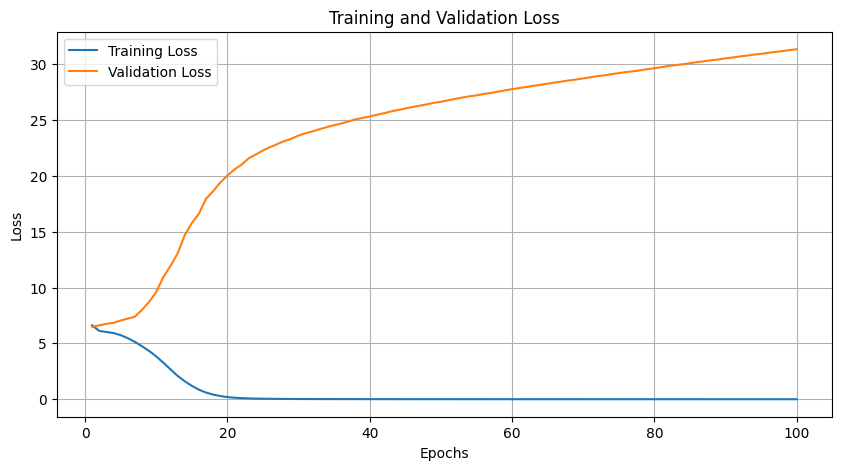

Generated Poem:
 zeus, the thunderer, cloud-gatherer folded built twenty servant home again yet,
twenty followed done minerva was phemius fallen,
twenty servant twenty done home father call,
twenty followed servant minerva as done husband


In [81]:
if __name__ == "__main__":
    seq_length = 5
    sequences, vocab_size, word_to_idx, idx_to_word = preprocess_corpus(corpus, seq_length)
    
    dataset = PoemDataset(sequences)
    model = PoemGenerator(vocab_size, embedding_dim=100, hidden_dim=100)
    train_losses, val_losses = train_model(model, dataset, epochs=100, batch_size=32)
    
    seed_text = "Zeus, the thunderer,"
    generated_poem = generate_poem(model, word_to_idx, idx_to_word, seed_text, seq_length, num_words=32, temperature=0.5, repetition_penalty=0.05)
    print("Generated Poem:\n", generated_poem)